# Домашняя работа 3. Логистическая регрессия. Работа с синтетическими данными

## Импорт библиотек и классов

Импортируем библиотеки

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics 

Класс Линейной регрессии без регуляризации

In [2]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #Прямое распространение
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #Рассчет потерь MSE
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #Рассчет градиента 
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #Обновление весов с учетом шага и градиента
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #Инициализация весов
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #Прогнозирование целевой переменной с текущей моделью
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #Оценка работы модели
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #Обучение модели
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #Загрузка батча
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #Добавление колонки смещения
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #Построение графика потерь для проверки работы алгоритма
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #Возвращение текущих весов w1, w2, ..., wn и b
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Класс линейной регрессии с регуляризацией Тихонова (L2)

In [3]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #Подсчет ошибок
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #Обновление весов с учетом "штрафа" за большие размеры
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  

Класс линейной регрессии с L1 регуляризацией 

In [4]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #Рассчет среднеквадратической ошибки
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #Обновление весов с учетом шага, градиента и "штрафа" за размер весов
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Класс логистической регрессии с регуляризацией L1

In [112]:
_EPS_ = 1e-6

class LogisticRegressionL1(LassoRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #Рассчет ошибки с учетом размера весов   
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term  
    #Функция активации для определения вероятности принадлежности к классу 1
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #Прямое распространение
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #Определение класса на основании logit, полученного с помощью сигмоиды
    def to_class(self,logit):
        return (logit>=self.threshold)*1   

    #Предсказание класса
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #Предсказание значений целевой переменной
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 

    # Оценка работы моделм
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size

    # Визуализация разделения на классы
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

    #Выведение метрик классификации
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Класс логистической регрессии с регуляризацией L2

In [113]:
_EPS_ = 1e-6

class LogisticRegressionL2(RidgeRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #Рассчет потерь с учетом размера весов  
    def loss(self,yhat, y):
        
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l2_term   
    #Функция активации
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #Прямое распространение
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #Определение класса по результатам применения сигмоиды
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #предсказание класса
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #Предсказание значения целевой переменной
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #Оценка работы модели
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #Визуализация разделения объектов на классы
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #Вывод метрик классификации
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Функция для визуализации данных

In [114]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Функции генерации и зашумления данных

In [274]:
N = 250


def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )
        
    return X,y

Для полиномиальной регрессии -- функция, преобразующяя входные данные в полином

In [30]:
def to_polynom(X, order = 2):
    order_range = range(order, order+1, 1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

## Датасет 1. Круги

Генерируем датасет

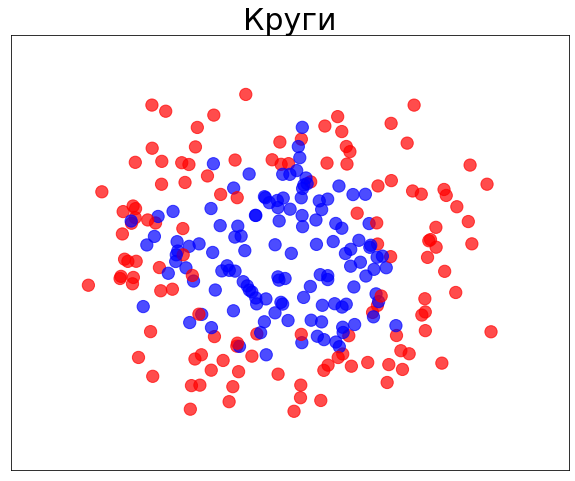

In [276]:
X, y = make_binary_clf (N, method = 'circles', noises = 0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Круги')

### Полином 2 степени

In [277]:
X_poly = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

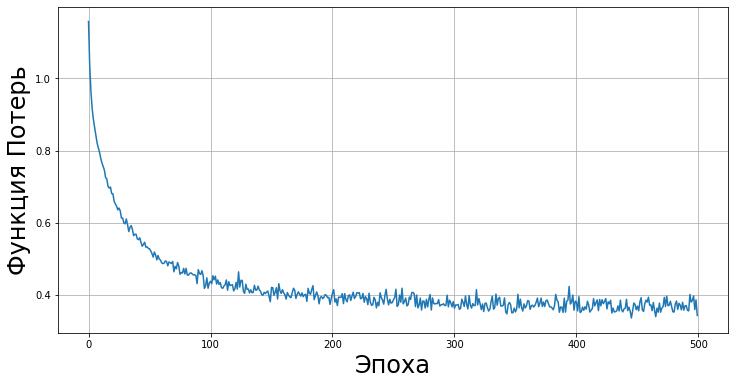

0.8266666666666667 0.8628571428571429
True Positives:0.7955	True Negatives:0.8710
False Positives:0.2045	False Negatives:0.1290
Accuracy:0.8267
Recall:0.8974	Precision:0.7955
f1 measure:0.8434


In [278]:
regr = LogisticRegressionL1(learning_rate=0.15,
                          epochs=500, batch_size=50,
                          l1_penalty = 0.0015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

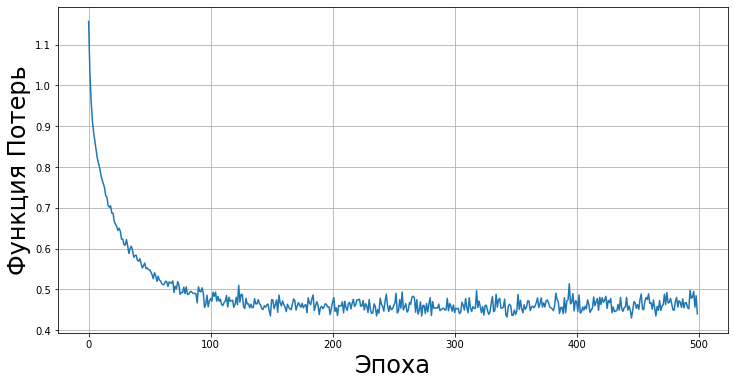

0.8266666666666667 0.8571428571428571
True Positives:0.7955	True Negatives:0.8710
False Positives:0.2045	False Negatives:0.1290
Accuracy:0.8267
Recall:0.8974	Precision:0.7955
f1 measure:0.8434


In [279]:
regr = LogisticRegressionL2(learning_rate=0.15,
                          epochs=500, batch_size=50,
                          l2_penalty = 0.0015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

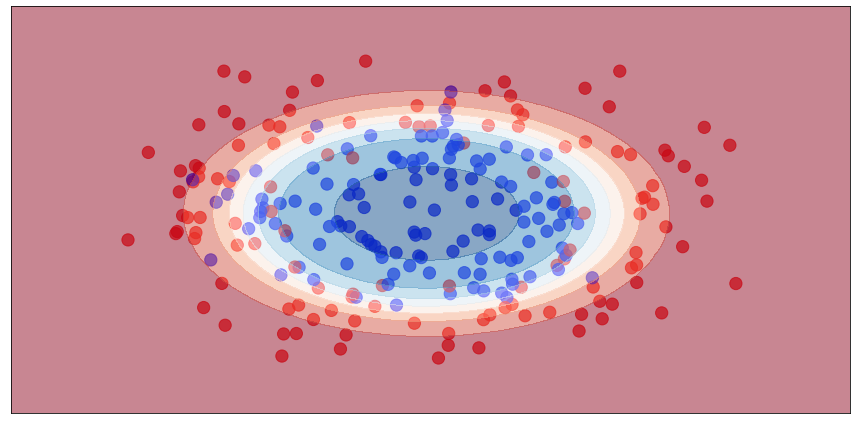

In [280]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

Результаты одинаковы для обоих типов регуляризации

### Полином 3 степени

In [281]:
X_poly = to_polynom(X, order = 3)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

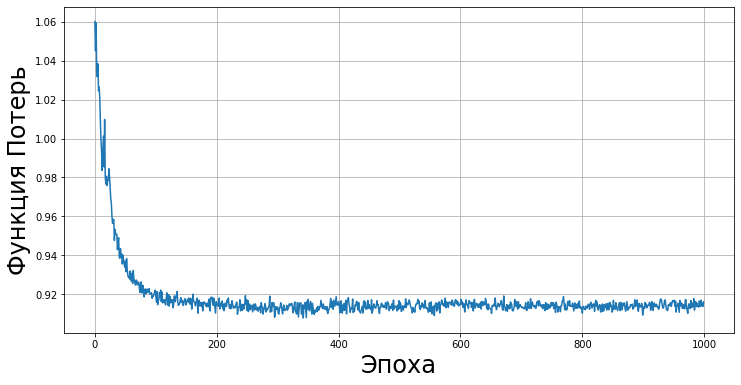

0.48 0.5142857142857142
True Positives:0.5000	True Negatives:0.4595
False Positives:0.5000	False Negatives:0.5405
Accuracy:0.4800
Recall:0.4872	Precision:0.5000
f1 measure:0.4935


In [282]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=1000, batch_size=50,
                          l1_penalty = 0.015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

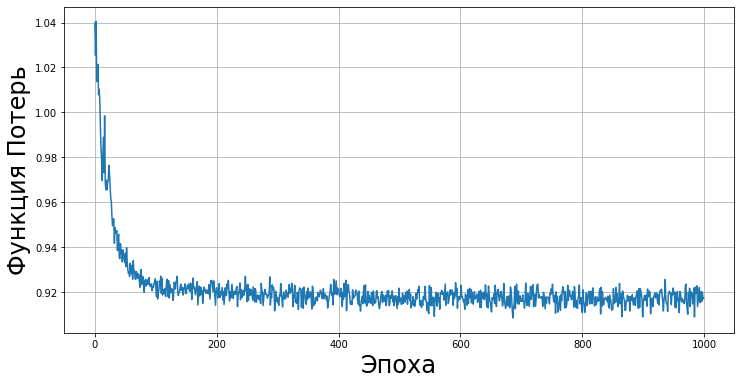

0.4533333333333333 0.5142857142857142
True Positives:0.4667	True Negatives:0.4444
False Positives:0.5333	False Negatives:0.5556
Accuracy:0.4533
Recall:0.3590	Precision:0.4667
f1 measure:0.4058


In [284]:
regr = LogisticRegressionL2(learning_rate=0.015,
                          epochs=1000, batch_size=50,
                          l2_penalty = 0.009)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Результат довольно низкий, но выше для L1 регуляризации

### Полином 5 степени

In [285]:
X_poly = to_polynom(X, order = 5)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

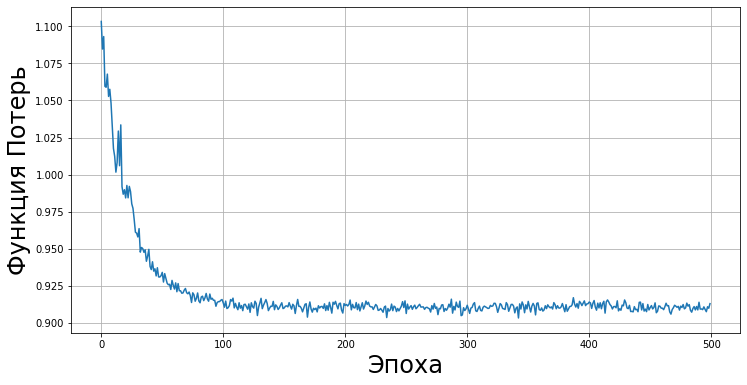

0.4666666666666667 0.5314285714285715
True Positives:0.4872	True Negatives:0.4444
False Positives:0.5128	False Negatives:0.5556
Accuracy:0.4667
Recall:0.4872	Precision:0.4872
f1 measure:0.4872


In [286]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=500, batch_size=50,
                          l1_penalty = 0.015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

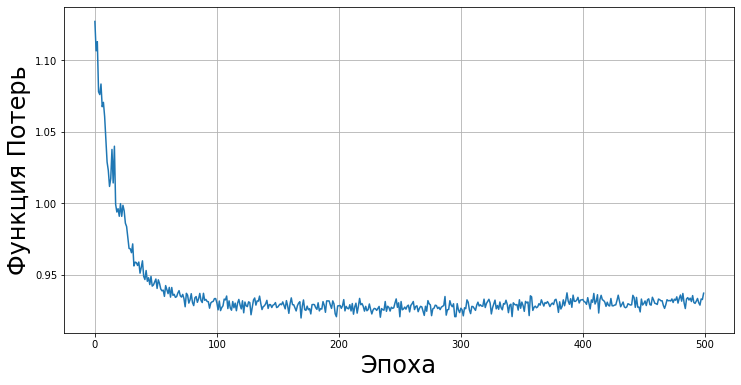

0.5066666666666667 0.5428571428571428
True Positives:0.5263	True Negatives:0.4865
False Positives:0.4737	False Negatives:0.5135
Accuracy:0.5067
Recall:0.5128	Precision:0.5263
f1 measure:0.5195


In [287]:
regr = LogisticRegressionL2(learning_rate=0.015,
                          epochs=500, batch_size=50,
                          l2_penalty = 0.1)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Результат выше для L2 регуляризации

### Полином 8 степени

In [288]:
X_poly = to_polynom(X, order = 8)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

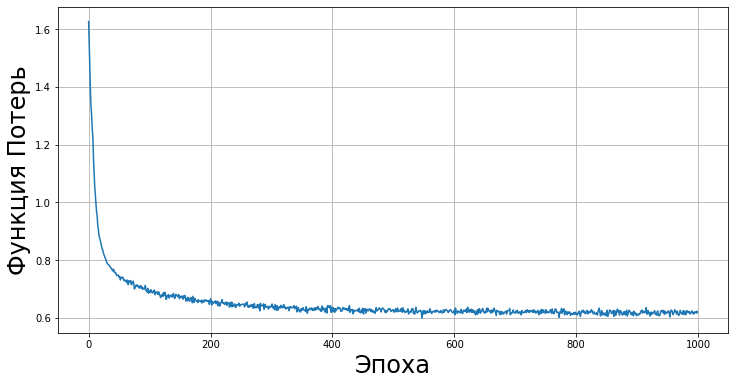

0.8 0.8571428571428571
True Positives:0.7500	True Negatives:0.8889
False Positives:0.2500	False Negatives:0.1111
Accuracy:0.8000
Recall:0.9231	Precision:0.7500
f1 measure:0.8276


In [289]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=1000, batch_size=50,
                          l1_penalty = 0.1)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

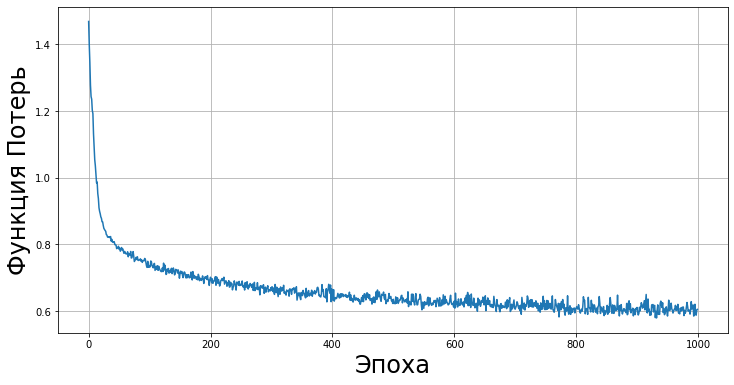

0.76 0.8114285714285714
True Positives:0.6981	True Negatives:0.9091
False Positives:0.3019	False Negatives:0.0909
Accuracy:0.7600
Recall:0.9487	Precision:0.6981
f1 measure:0.8043


In [290]:
regr = LogisticRegressionL2(learning_rate=0.015,
                          epochs=1000, batch_size=50,
                          l2_penalty = 0.00015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Результат выше для L1 регуляризации

**Лучше всего с данными в виде кругов справился полином 2 степени. Результат одинаково хорош с различными типами регуляризации. Когда степень доходит до 8, показатели начинают улучшаться рпи использовании L1 регуляризации, но все равно остаются хуже, чем у полинома 2 степени.**

## Инь-янь

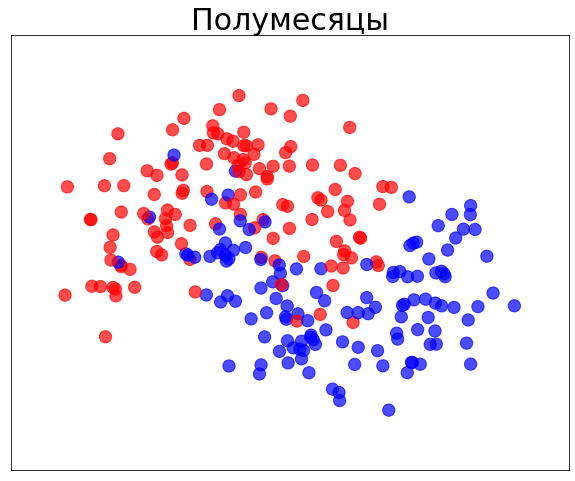

In [293]:
X, y = make_binary_clf (N, method = 'moons', noises = 0.3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Полумесяцы')

### Полином 2 степени

In [294]:
X_poly = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

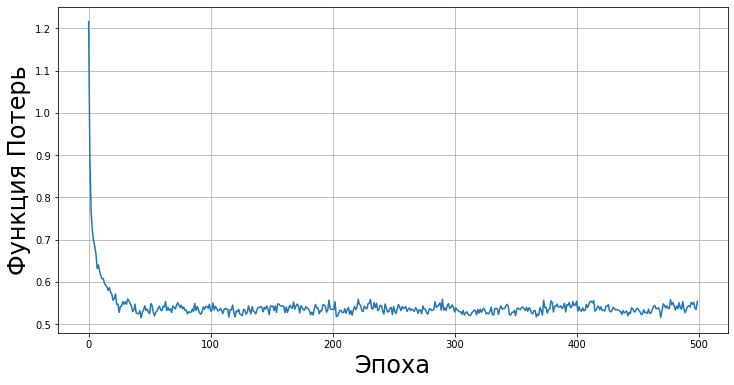

0.8533333333333334 0.7942857142857143
True Positives:0.8333	True Negatives:0.8788
False Positives:0.1667	False Negatives:0.1212
Accuracy:0.8533
Recall:0.8974	Precision:0.8333
f1 measure:0.8642


In [295]:
regr = LogisticRegressionL1(learning_rate=0.15,
                          epochs=500, batch_size=50,
                          l1_penalty = 0.2)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

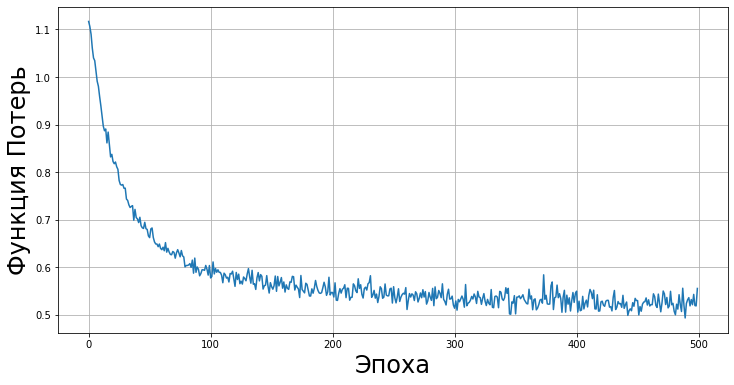

0.88 0.8171428571428572
True Positives:0.8750	True Negatives:0.8857
False Positives:0.1250	False Negatives:0.1143
Accuracy:0.8800
Recall:0.8974	Precision:0.8750
f1 measure:0.8861


In [296]:
regr = LogisticRegressionL2(learning_rate=0.01,
                          epochs=500, batch_size=50,
                          l2_penalty = 0.001)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

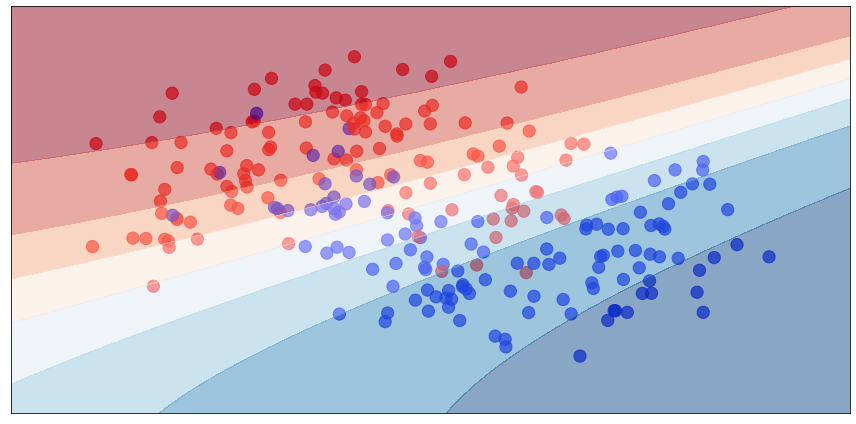

In [297]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

Результат лучше для L2 регуляризации

### Полином 3 степени

In [298]:
X_poly = to_polynom(X, order = 3)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

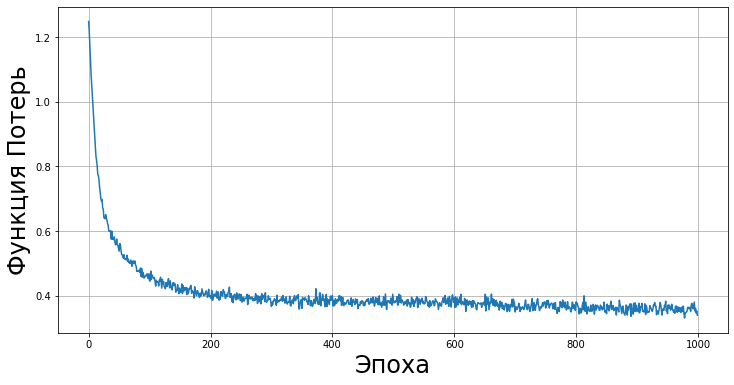

0.84 0.8171428571428572
True Positives:0.8462	True Negatives:0.8333
False Positives:0.1538	False Negatives:0.1667
Accuracy:0.8400
Recall:0.8462	Precision:0.8462
f1 measure:0.8462


In [299]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=1000, batch_size=50,
                          l1_penalty = 0.1)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

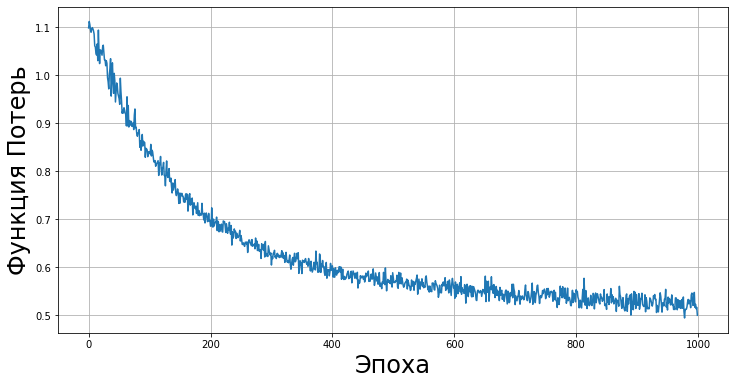

0.84 0.7942857142857143
True Positives:0.8649	True Negatives:0.8158
False Positives:0.1351	False Negatives:0.1842
Accuracy:0.8400
Recall:0.8205	Precision:0.8649
f1 measure:0.8421


In [300]:
regr = LogisticRegressionL2(learning_rate=0.0015,
                          epochs=1000, batch_size=50,
                          l2_penalty = 0.0001)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Результаты лучше для L2 регуляризации

### Полином 5 степени

In [301]:
X_poly = to_polynom(X, order = 5)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

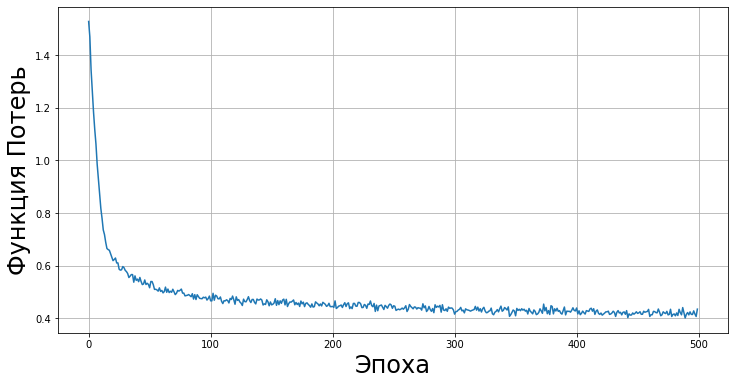

0.8266666666666667 0.8114285714285714
True Positives:0.8421	True Negatives:0.8108
False Positives:0.1579	False Negatives:0.1892
Accuracy:0.8267
Recall:0.8205	Precision:0.8421
f1 measure:0.8312


In [302]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=500, batch_size=50,
                          l1_penalty = 0.2)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

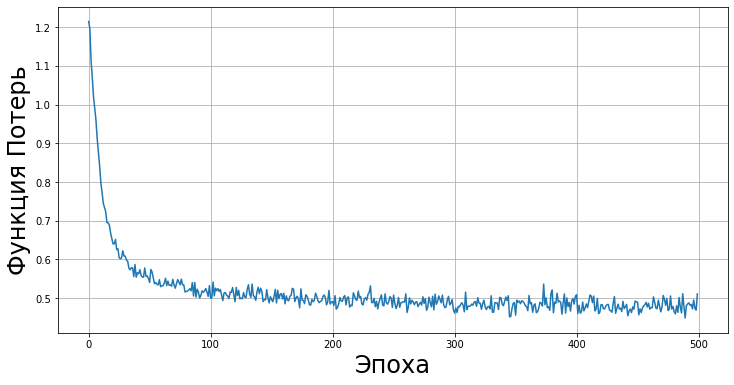

0.8666666666666667 0.8285714285714286
True Positives:0.8718	True Negatives:0.8611
False Positives:0.1282	False Negatives:0.1389
Accuracy:0.8667
Recall:0.8718	Precision:0.8718
f1 measure:0.8718


In [303]:
regr = LogisticRegressionL2(learning_rate=0.015,
                          epochs=500, batch_size=50,
                          l2_penalty = 0.001)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Результат выше для L2 регуляризации

### Полином 8 степени

In [304]:
X_poly = to_polynom(X, order = 8)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

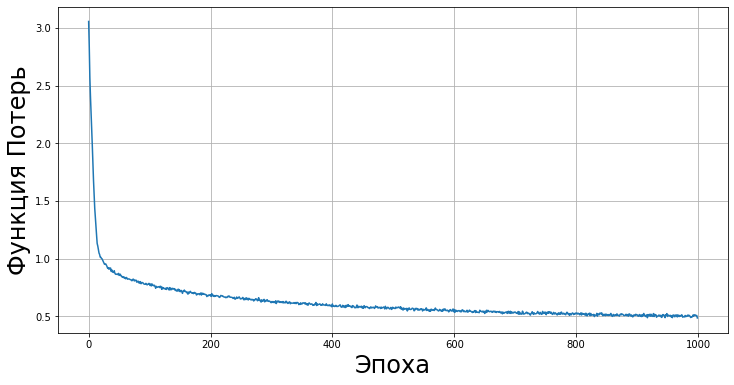

0.8266666666666667 0.8114285714285714
True Positives:0.8421	True Negatives:0.8108
False Positives:0.1579	False Negatives:0.1892
Accuracy:0.8267
Recall:0.8205	Precision:0.8421
f1 measure:0.8312


In [305]:
regr = LogisticRegressionL1(learning_rate=0.015,
                          epochs=1000, batch_size=100,
                          l1_penalty = 0.1)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

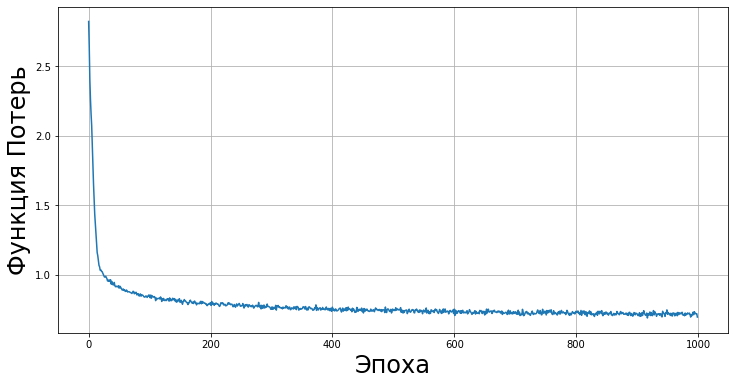

0.8533333333333334 0.84
True Positives:0.8500	True Negatives:0.8571
False Positives:0.1500	False Negatives:0.1429
Accuracy:0.8533
Recall:0.8718	Precision:0.8500
f1 measure:0.8608


In [306]:
regr = LogisticRegressionL2(learning_rate=0.015,
                          epochs=1000, batch_size=100,
                          l2_penalty = 0.0001)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

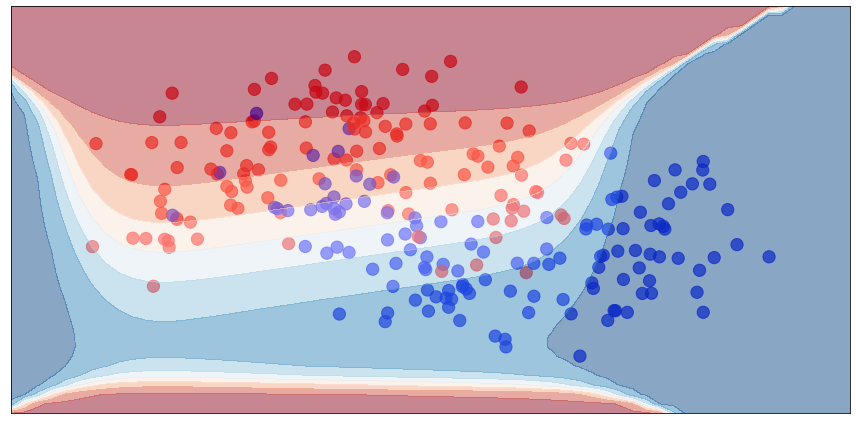

In [307]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 8)

Результат выше для L2 регуляризации

### Полином 12  степени

In [308]:
X_poly = to_polynom(X, order = 12)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

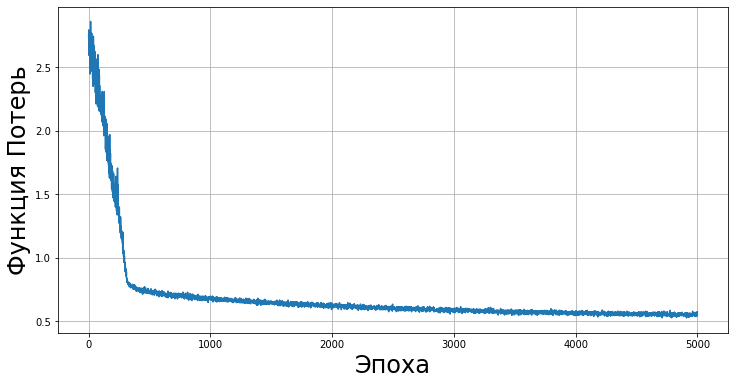

0.8533333333333334 0.8057142857142857
True Positives:0.8333	True Negatives:0.8788
False Positives:0.1667	False Negatives:0.1212
Accuracy:0.8533
Recall:0.8974	Precision:0.8333
f1 measure:0.8642


In [323]:
regr = LogisticRegressionL1(learning_rate=0.0001,
                          epochs=5000, batch_size=50,
                          l1_penalty = 0.1)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

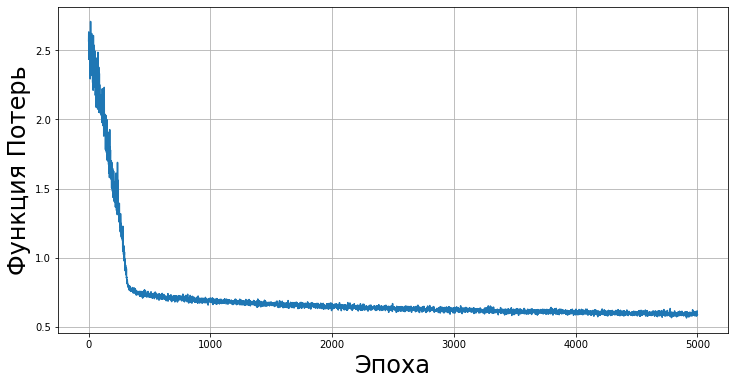

0.8266666666666667 0.7828571428571428
True Positives:0.7955	True Negatives:0.8710
False Positives:0.2045	False Negatives:0.1290
Accuracy:0.8267
Recall:0.8974	Precision:0.7955
f1 measure:0.8434


In [320]:
regr = LogisticRegressionL2(learning_rate=0.0001,
                          epochs=5000, batch_size=50,
                          l2_penalty = 0.015)

regr.fit (X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

**Самых высоких показателей с данными в виде двух полумесяцев удалось добиться при использовании 3 степени полинома. В среднем результат выше с L2 регуляризацией.**

### Вывод

Использование различных степеней полиномов и типов регуляризации показало, что повышение степени не всегда оправдано. На данных, сгенерированных нами, лучше всего сработали полиномы 2 и 3 степеней, в то время как полиномы 8 и более степеней требовали больше эпох обучения и все равно показывали более низкие результаты. Выбор регуляризации также зависит от исходных данных. Так, в случае с кругами лучше работала L1 регуляризация, а в случае с полумесяцами -- L2 регуляризация.